In [1]:
from pandas import DataFrame
from MyModule import load_data

train_data = load_data("train_raw.txt")
val_data = load_data("val_raw.txt")
test_data = load_data("test_raw.txt")

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer


class WeiboDataset(Dataset):
    def __init__(self, data: DataFrame, tokenizer, max_len=128):
        self.texts = data[0]
        self.labels = data[1]
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            truncation=True, 
            padding='max_length', 
            max_length=self.max_len, 
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0), 
            'attention_mask': encoding["attention_mask"].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }



tokenizer = BertTokenizer.from_pretrained("./models/chinese-macbert-base")

max_len = 64
train_dataset = WeiboDataset(train_data, tokenizer, max_len)
val_dataset = WeiboDataset(val_data, tokenizer, max_len)
test_dataset = WeiboDataset(test_data, tokenizer, max_len)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [3]:
from transformers import BertModel
import torch.nn as nn

class BertForWeiboSentiment(nn.Module):
    def __init__(self, model_name, num_class=3) -> None:
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_class)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        out = self.fc(self.dropout(cls_output))
        return out

In [4]:
from tqdm.auto import tqdm

# from torch.cuda.amp import autocast, GradScaler
from torch.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForWeiboSentiment("./models/chinese-macbert-base").to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-3)
num_epochs = 5

total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

scaler = GradScaler('cuda')
accum_steps = 2

In [5]:
# 预训练语言模型的通用训练验证与测试函数
import copy
from sklearn.metrics import precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt

from MyModule import (
    plot_confusion_matrix, 
    plot_training_curves, 
    print_training_summary, 
    save_training_results
)

def train_bert_model_with_validation(
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler=None,
    criterion=nn.CrossEntropyLoss(), 
    num_epochs=5, 
    device=torch.device('cuda'), 
    target_names=['Negative', 'Neutral', 'Positive'],
    patience=3,
    min_delta=0.001,
    use_amp=True,
    accum_steps=1,
    max_grad_norm=1.0
):
    """
    BERT模型训练函数，支持验证集评估和早停机制
    
    Args:
        model: BERT模型
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        optimizer: 优化器
        scheduler: 学习率调度器 (可选)
        criterion: 损失函数
        num_epochs: 训练轮数
        device: 设备 (cpu/cuda)
        target_names: 类别名称列表
        patience: 早停耐心值，验证损失不下降的最大轮数
        min_delta: 最小改善阈值
        use_amp: 是否使用混合精度训练
        accum_steps: 梯度累积步数
        max_grad_norm: 梯度裁剪最大范数
        
    Returns:
        dict: 包含训练历史的字典
    """
    
    # 训练历史记录
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': [],
        'val_f1_scores': [],
        'val_precision_scores': [],
        'val_recall_scores': []
    }
    
    # 早停相关变量
    if patience is not None and val_loader is not None:
        best_val_loss = float('inf')
        patience_counter = 0
        best_model_state = None
    
    # 混合精度训练
    if use_amp:
        scaler = GradScaler('cuda')
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_train_loss = 0
        train_correct = 0
        train_total = 0
        
        for step, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, targets) / accum_steps
                
                scaler.scale(loss).backward()
                
                if (step + 1) % accum_steps == 0 or (step + 1) == len(train_loader):
                    if max_grad_norm > 0:
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    scaler.step(optimizer)
                    scaler.update()
                    if scheduler is not None:
                        scheduler.step()
                    optimizer.zero_grad()
            else:
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets) / accum_steps
                
                loss.backward()
                
                if (step + 1) % accum_steps == 0 or (step + 1) == len(train_loader):
                    if max_grad_norm > 0:
                        nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                    optimizer.step()
                    if scheduler is not None:
                        scheduler.step()
                    optimizer.zero_grad()
            
            total_train_loss += loss.item() * accum_steps
            preds = logits.argmax(dim=1)
            train_correct += (preds == targets).sum().item()
            train_total += targets.size(0)
        
        # 记录训练指标
        avg_train_loss = total_train_loss / len(train_loader)
        train_acc = train_correct / train_total
        history['train_losses'].append(avg_train_loss)
        history['train_accuracies'].append(train_acc)
        
        # 验证阶段
        if val_loader is not None:
            val_metrics = evaluate_bert_model(model, val_loader, criterion, device, use_amp)
            history['val_losses'].append(val_metrics['loss'])
            history['val_accuracies'].append(val_metrics['accuracy'])
            history['val_f1_scores'].append(val_metrics['f1'])
            history['val_precision_scores'].append(val_metrics['precision'])
            history['val_recall_scores'].append(val_metrics['recall'])
            
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train Loss: {avg_train_loss:.4f}\tTrain Accuracy: {train_acc:.4f}")
            print(f"    Valid Loss: {val_metrics['loss']:.4f}\tValid Accuracy: {val_metrics['accuracy']:.4f}")
            print(f"    Valid Precision: {val_metrics['precision']:.4f}\tValid Recall: {val_metrics['recall']:.4f}\tValid F1: {val_metrics['f1']:.4f}")
            
            # 早停检查
            if patience is not None:
                current_val_loss = val_metrics['loss']
                if current_val_loss < best_val_loss - min_delta:
                    best_val_loss = current_val_loss
                    patience_counter = 0
                    best_model_state = copy.deepcopy(model.state_dict())
                    print(f"    ✓ New best validation loss: {best_val_loss:.4f}")
                else:
                    patience_counter += 1
                    print(f"    No improvement. Patience: {patience_counter}/{patience}")
                    
                if patience_counter >= patience:
                    print(f"    Early stopping triggered! Best validation loss: {best_val_loss:.4f}")
                    model.load_state_dict(best_model_state)
                    break
            
            print('-' * 80)
            
            # 最后一个epoch打印详细报告
            if epoch == num_epochs - 1:
                print("\nDetailed Classification Report:")
                print(classification_report(val_metrics['true_labels'], val_metrics['pred_labels'], 
                                          target_names=target_names, digits=4))
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_train_loss:.4f} - Accuracy: {train_acc:.4f}")
    
    # 添加早停信息到历史记录
    if patience is not None and val_loader is not None:
        history['early_stopped'] = patience_counter >= patience
        history['best_val_loss'] = best_val_loss
        history['stopped_epoch'] = epoch + 1 if patience_counter >= patience else num_epochs
    
    return history

def evaluate_bert_model(
    model, 
    data_loader, 
    criterion=nn.CrossEntropyLoss(), 
    device=torch.device('cuda'),
    use_amp=True
):
    """
    BERT模型评估函数
    
    Args:
        model: BERT模型
        data_loader: 数据加载器
        criterion: 损失函数
        device: 设备
        use_amp: 是否使用混合精度
        
    Returns:
        dict: 评估结果字典
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
                    loss = criterion(logits, targets)
            else:
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, targets)
            
            total_loss += loss.item()
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_labels': all_targets,
        'pred_labels': all_preds
    }

def test_bert_model_comprehensive(
    model, 
    model_name, 
    test_loader, 
    device=torch.device('cuda'), 
    target_names=['Negative', 'Neutral', 'Positive'],
    use_amp=True
):
    """
    全面的BERT模型测试函数，包含F1分数和混淆矩阵
    
    Args:
        model: BERT模型
        model_name: 模型名称
        test_loader: 测试数据加载器
        device: 设备
        target_names: 类别名称列表
        use_amp: 是否使用混合精度
        
    Returns:
        dict: 测试结果字典
    """
    model.eval()
    all_preds = []
    all_targets = []
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['label'].to(device)
            
            if use_amp:
                with autocast('cuda'):
                    logits = model(input_ids, attention_mask)
            else:
                logits = model(input_ids, attention_mask)
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    # 计算指标
    test_accuracy = correct / total
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted', zero_division=0
    )
    
    # 计算每个类别的指标
    class_precision, class_recall, class_f1, class_support = precision_recall_fscore_support(
        all_targets, all_preds, average=None, zero_division=0
    )
    
    # 输出结果
    print("\n" + "="*80)
    print("BERT MODEL TEST RESULTS")
    print("="*80)
    print(f"Model Name: {model_name}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision (weighted): {test_precision:.4f}")
    print(f"Test Recall (weighted): {test_recall:.4f}")
    print(f"Test F1 Score (weighted): {test_f1:.4f}")
    
    # 详细分类报告
    print("\nDetailed Test Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=target_names, digits=4))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(model_name, all_targets, all_preds, target_names)

    # 打印每个类别的指标
    print("\nPer-Class Metrics:")
    print("-" * 60)
    for i, class_name in enumerate(target_names):
        print(f"{class_name:>8}: Precision={class_precision[i]:.4f}, "
              f"Recall={class_recall[i]:.4f}, F1={class_f1[i]:.4f}, "
              f"Support={int(class_support[i])}")
    
    return {
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': test_f1,
        'class_metrics': {
            'precision': class_precision,
            'recall': class_recall,
            'f1': class_f1,
            'support': class_support
        }
    }

In [6]:
# 重新初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert = BertForWeiboSentiment("./models/chinese-macbert-base").to(device)

# 设置训练参数
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(bert.parameters(), lr=2e-5, weight_decay=1e-3)
num_epochs = 10

# 学习率调度器
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, int(0.1*total_steps), total_steps)

In [7]:
# 使用通用训练函数
bert_history = train_bert_model_with_validation(
    model=bert,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    num_epochs=num_epochs,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive'],
    patience=3,          # 早停耐心值
    min_delta=0.001,     # 最小改善阈值
    use_amp=True,        # 使用混合精度训练
    accum_steps=2,       # 梯度累积步数
    max_grad_norm=1.0    # 梯度裁剪
)

Training Epoch 1: 100%|██████████| 7827/7827 [13:06<00:00,  9.95it/s]


Epoch 1/10
    Train Loss: 0.6788	Train Accuracy: 0.7010
    Valid Loss: 0.4967	Valid Accuracy: 0.7968
    Valid Precision: 0.7880	Valid Recall: 0.7968	Valid F1: 0.7877
    ✓ New best validation loss: 0.4967
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 7827/7827 [13:11<00:00,  9.88it/s]


Epoch 2/10
    Train Loss: 0.4914	Train Accuracy: 0.7961
    Valid Loss: 0.4659	Valid Accuracy: 0.8108
    Valid Precision: 0.8050	Valid Recall: 0.8108	Valid F1: 0.8036
    ✓ New best validation loss: 0.4659
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 7827/7827 [13:11<00:00,  9.89it/s]


Epoch 3/10
    Train Loss: 0.4401	Train Accuracy: 0.8170
    Valid Loss: 0.4358	Valid Accuracy: 0.8221
    Valid Precision: 0.8197	Valid Recall: 0.8221	Valid F1: 0.8206
    ✓ New best validation loss: 0.4358
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 7827/7827 [13:11<00:00,  9.88it/s]


Epoch 4/10
    Train Loss: 0.4007	Train Accuracy: 0.8347
    Valid Loss: 0.4310	Valid Accuracy: 0.8262
    Valid Precision: 0.8217	Valid Recall: 0.8262	Valid F1: 0.8228
    ✓ New best validation loss: 0.4310
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 7827/7827 [13:10<00:00,  9.90it/s]


Epoch 5/10
    Train Loss: 0.3713	Train Accuracy: 0.8479
    Valid Loss: 0.4470	Valid Accuracy: 0.8269
    Valid Precision: 0.8213	Valid Recall: 0.8269	Valid F1: 0.8221
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 7827/7827 [13:09<00:00,  9.91it/s]


Epoch 6/10
    Train Loss: 0.3408	Train Accuracy: 0.8607
    Valid Loss: 0.4519	Valid Accuracy: 0.8285
    Valid Precision: 0.8235	Valid Recall: 0.8285	Valid F1: 0.8249
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 7827/7827 [13:09<00:00,  9.91it/s]


Epoch 7/10
    Train Loss: 0.3155	Train Accuracy: 0.8729
    Valid Loss: 0.4487	Valid Accuracy: 0.8303
    Valid Precision: 0.8262	Valid Recall: 0.8303	Valid F1: 0.8276
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.4310


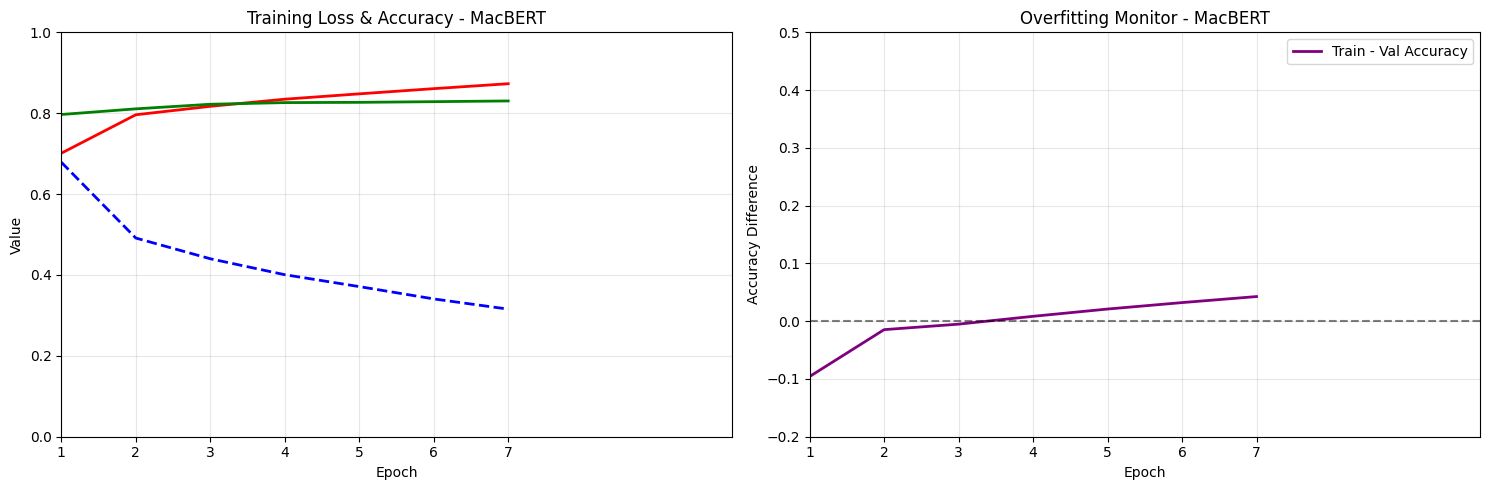


TRAINING SUMMARY
Model Name: MacBERT
Final Train Loss: 0.3155
Final Train Accuracy: 0.8729
Final Val Loss: 0.4487
Final Val Accuracy: 0.8303
Best Val Accuracy: 0.8303 (Epoch 7)
Final Overfitting Gap: 0.0426


In [8]:
# 绘制训练曲线
plot_training_curves("MacBERT", bert_history)

# 打印训练摘要
print_training_summary("MacBERT", bert_history)

Testing: 100%|██████████| 53687/53687 [06:48<00:00, 131.44it/s]



BERT MODEL TEST RESULTS
Model Name: MacBERT
Test Accuracy: 0.8243
Test Precision (weighted): 0.8200
Test Recall (weighted): 0.8243
Test F1 Score (weighted): 0.8210

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8321    0.8959    0.8629     18614
     Neutral     0.6698    0.5739    0.6181      9924
    Positive     0.8702    0.8701    0.8701     25149

    accuracy                         0.8243     53687
   macro avg     0.7907    0.7800    0.7837     53687
weighted avg     0.8200    0.8243    0.8210     53687



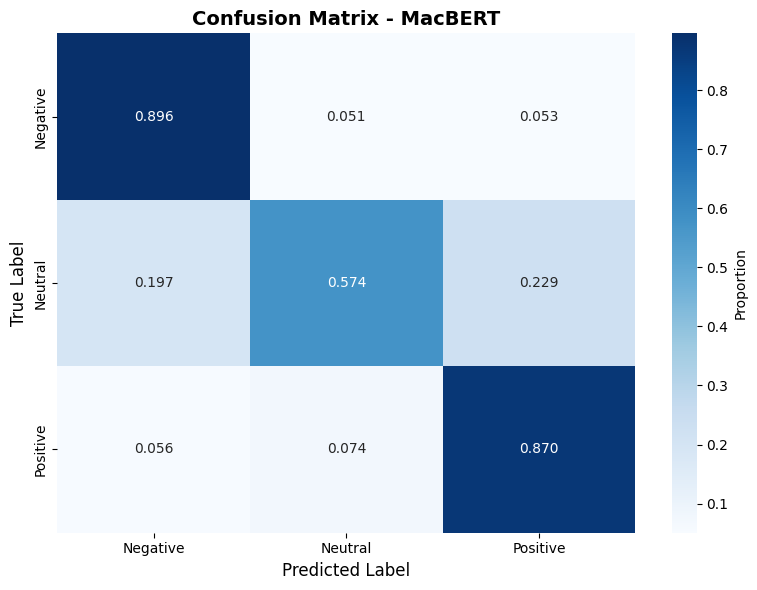


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8321, Recall=0.8959, F1=0.8629, Support=18614
 Neutral: Precision=0.6698, Recall=0.5739, F1=0.6181, Support=9924
Positive: Precision=0.8702, Recall=0.8701, F1=0.8701, Support=25149


In [9]:
# 进行全面测试
bert_test_results = test_bert_model_comprehensive(
    model=bert,
    model_name="MacBERT",
    test_loader=test_loader,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive'],
    use_amp=True
)


In [11]:
save_training_results(
    model=bert, 
    model_name="MacBERT", 
    actual_epochs=len(bert_history['train_losses']), 
    device=device, 
    use_pretrained_embeddings=False, 
    training_history=bert_history, 
    test_results=bert_test_results, 
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: MacBERT (BertForWeiboSentiment)
  - 实际训练轮数: 7
  - 测试准确率: 0.8243
  - 测试F1分数: 0.8210
  - 记录时间: 2025-11-15 11:14:26
  - 总记录数: 8


{'model_class': 'BertForWeiboSentiment',
 'model_name': 'MacBERT',
 'actual_epochs': 7,
 'device': 'cuda',
 'use_pretrained_embeddings': False,
 'training_history': {'train_losses': [0.6788359491536028,
   0.4913581022056291,
   0.44008820206098237,
   0.40068123647920534,
   0.37125606699051245,
   0.3407830419020055,
   0.3155185852308786],
  'train_accuracies': [0.7009909607767982,
   0.7961184042417273,
   0.8170156190111154,
   0.8346548805417146,
   0.8478823303947872,
   0.8607185064520251,
   0.8729278459179762],
  'val_losses': [0.49673326670484125,
   0.4658789854314671,
   0.43578539555614837,
   0.43101156504738175,
   0.4470464485976068,
   0.4518905822898087,
   0.4486519286899658],
  'val_accuracies': [0.7968103737377501,
   0.8107836196296159,
   0.8221485262883332,
   0.8262287140887581,
   0.8268621679025226,
   0.8285389574095465,
   0.8303089018891828],
  'early_stopped': True,
  'best_val_loss': 0.43101156504738175,
  'stopped_epoch': 7},
 'test_results': {'accurac